# Particle spray algorithm by Chen et al. (2024)

Author: Yingtian "Bill" Chen

We provide a notebook to generate streams using the Chen+24 ([arXiv:2408.01496](https://arxiv.org/abs/2408.01496)) model via `galax`. This implementation has been merged to the `main` branch of `galax` since [this commit](https://github.com/ybillchen/galax_chen24/commit/a663fc1c691e82f4f9b15e07bc68e58758eb169d).

Currently, you need to install `galax` from `GitHub` instead of `pypi` to use our model
```
$ git clone https://github.com/GalacticDynamics/galax.git
$ cd galax
$ python -m pip install .
```
If you already have `galax` installed, simply pull the latest updates and reinstall.

Note that `galax` curently doesn't support orbit integration with the progenitor's potential, which is required by our default model. Here, we provide an unofficial approach to include the progenitor's potential. 

## First, let's do particly spray without the progenitor's potential

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax.random as jr

from unxt import Quantity
import galax.coordinates as gc
import galax.potential as gp
import galax.dynamics as gd

In [2]:
pot = gp.BovyMWPotential2014()

w = gc.PhaseSpacePosition(q=Quantity([40, 0, 0], "kpc"),
                          p=Quantity([0, 100, 0], "km/s"),
                          t=Quantity(0, "Myr"))

t_array = Quantity(np.arange(500+1)*6, "Myr")
prog_mass = Quantity(1e5, "Msun")

In [3]:
# Fardal+15
df = gd.FardalStreamDF()
gen = gd.MockStreamGenerator(df, pot)
%time stream_f15, _ = gen.run(jr.key(0),t_array, w, prog_mass)

# Chen+24 (no prog.)
df = gd.ChenStreamDF()
gen = gd.MockStreamGenerator(df, pot)
%time stream_c24, _ = gen.run(jr.key(0),t_array, w, prog_mass)

CPU times: user 9.93 s, sys: 486 ms, total: 10.4 s
Wall time: 10.3 s


/Users/ybchen/Documents/galax_chen24/src/galax/dynamics/_dynamics/mockstream/df/chen24.py:52: RuntimeWarning: Currently only the "no progenitor" version of the Chen+24 model is supported!
  warnings.warn(


CPU times: user 7.94 s, sys: 376 ms, total: 8.32 s
Wall time: 8.15 s


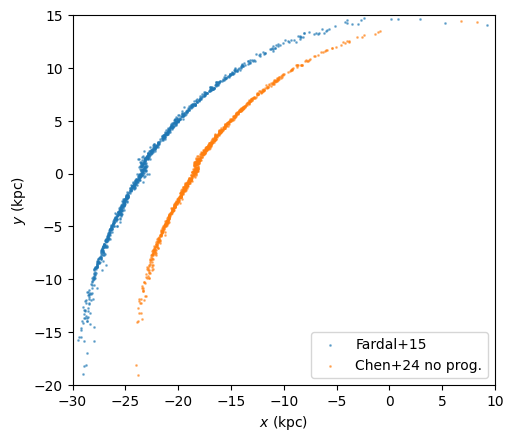

In [4]:
plt.scatter(stream_f15.q.x.value-5, stream_f15.q.y.value, s=1, alpha=0.5, label='Fardal+15')
plt.scatter(stream_c24.q.x.value, stream_c24.q.y.value, s=1, alpha=0.5, label='Chen+24 no prog.')

plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.xlim(-30, 10)
plt.ylim(-20, 15)
plt.legend()
plt.gca().set_aspect(1)
plt.show()

## Now, try to include the progenitor's potential

In [5]:
import warnings
from typing import final, Literal

from jax.lib.xla_bridge import get_backend
from plum import convert

import quaxed.numpy as jnp
from coordinax.operators import AbstractOperator
from coordinax.operators._base import op_call_dispatch
from coordinax import AbstractPosition3D, CartesianPosition3D

from galax.typing import QVecTime
from galax.coordinates._psp.base_psp import AbstractPhaseSpacePosition

**First, define a new translation operator class that moves a potential**

In [6]:
@final
class MovingOperator(AbstractOperator):

    q_array: AbstractPosition3D
    t_array: QVecTime
    
    @property
    def is_inertial(self) -> Literal[True]:
        return True

    @property
    def inverse(self) -> "MovingOperator":
        return MovingOperator(q_array=-self.q_array, t_array=self.t_array)

    @property
    def q_cart(self) -> CartesianPosition3D:
        return self.q_array.represent_as(CartesianPosition3D)

    @op_call_dispatch(precedence=1)
    def __call__(
        self: "MovingOperator",
        q: Quantity["length"],
        t: Quantity["time"],
        /,
    ) -> tuple[Quantity["length"], Quantity["time"]]:

        t_correct_unit = t.to_units_value(t_array.unit)

        dx = jnp.interp(t_correct_unit, self.t_array.value, self.q_cart.x.value)
        dy = jnp.interp(t_correct_unit, self.t_array.value, self.q_cart.y.value)
        dz = jnp.interp(t_correct_unit, self.t_array.value, self.q_cart.z.value)
        dq = Quantity([dx,dy,dz], self.q_cart.x.unit)
        return (q + dq, t)

    @op_call_dispatch(precedence=1)
    def __call__(
        self: "MovingOperator",
        vec: AbstractPosition3D,
        t: Quantity["time"],
        /,
    ) -> tuple[AbstractPosition3D, Quantity["time"]]:

        q = convert(vec.represent_as(CartesianPosition3D), Quantity)
        qp, tp = self(q, t)
        vecp = CartesianPosition3D.constructor(qp).represent_as(type(vec))
        return (vecp, tp)

    @op_call_dispatch
    def __call__(
        self: "MovingOperator", 
        psp: AbstractPhaseSpacePosition, 
        /,
    ) -> AbstractPhaseSpacePosition:

        q, t = self(psp.q, psp.t)
        p = psp.p.represent_as(CartesianVelocity3D, psp.q).represent_as(type(psp.p), q)
        # Reasseble and return
        return replace(psp, q=q, p=p, t=t)

**Next, generate initial conditions and integrate the orbits**

In [7]:
def run_with_prog(rng, df, pot, ts, prog_w0, prog_mass, prog_pot, vmapped=None):
    
    # Parse vmapped
    use_vmap = get_backend().platform == "gpu" if vmapped is None else vmapped
    
    prog_orbit = pot.evaluate_orbit(prog_w0, t=ts)
    
    arg = jnp.argsort(prog_orbit.t.value)
    op = MovingOperator(q_array=prog_orbit.q[arg], t_array=prog_orbit.t[arg])
        
    prog_pot_moving = gp.PotentialFrame(original_potential=prog_pot, operator=op)
    pot_tot = pot + prog_pot_moving
    
    gen = gd.MockStreamGenerator(df, pot_tot)
    
    # Generate initial conditions
    mock0 = df.sample(jr.key(0), pot, prog_orbit, prog_mass)
    
    # Integrate the orbit
    if use_vmap:
        lead_arm_w, trail_arm_w = gen._run_vmap(ts, mock0["lead"], mock0["trail"])
    else:
        lead_arm_w, trail_arm_w = gen._run_scan(ts, mock0["lead"], mock0["trail"])
    
    comps = {}
    comps["lead"] = gd.MockStreamArm(
        q=Quantity(lead_arm_w[:, 0:3], gen.units["length"]),
        p=Quantity(lead_arm_w[:, 3:6], gen.units["speed"]),
        t=ts,
        release_time=mock0["lead"].release_time,
    )
    comps["trail"] = gd.MockStreamArm(
        q=Quantity(trail_arm_w[:, 0:3], gen.units["length"]),
        p=Quantity(trail_arm_w[:, 3:6], gen.units["speed"]),
        t=ts,
        release_time=mock0["trail"].release_time,
    )
    
    return gd.MockStream(comps), prog_orbit[-1]

In [8]:
# Chen+24 (with prog.)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    df = gd.ChenStreamDF()
        
prog_pot = gp.PlummerPotential(m_tot=prog_mass, b=Quantity(4, 'pc'), units='galactic')
%time stream_c24b, _ = run_with_prog(jr.key(0), df, pot, t_array, w, prog_mass, prog_pot)

CPU times: user 10.3 s, sys: 413 ms, total: 10.8 s
Wall time: 10.6 s


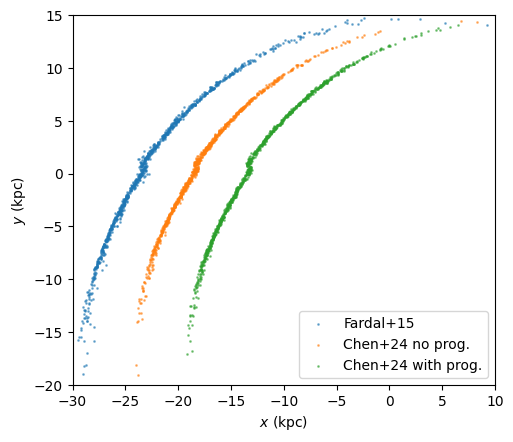

In [9]:
plt.scatter(stream_f15.q.x.value-5, stream_f15.q.y.value, s=1, alpha=0.5, label='Fardal+15')
plt.scatter(stream_c24.q.x.value, stream_c24.q.y.value, s=1, alpha=0.5, label='Chen+24 no prog.')
plt.scatter(stream_c24b.q.x.value+5, stream_c24b.q.y.value, s=1, alpha=0.5, label='Chen+24 with prog.')

plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.xlim(-30, 10)
plt.ylim(-20, 15)
plt.legend()
plt.gca().set_aspect(1)
plt.show()